Analysis of terrains generated by our CPPN.

# Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import pandas as pd
import math
from datetime import date

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/XXX/Documents/TeachMyAgent/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import gym
import teachDRL.gym_flowers_v2

# Utils

In [3]:
H_DIM = 200
W_DIM = 200

In [4]:
random_state = np.random.RandomState(43)

In [5]:
def clip_ceiling_values(row, clip_offset):
    if row["ceiling"] >= row["ground"] + clip_offset:
        return row["ceiling"]
    else:
        return row["ground"] + clip_offset

def get_plot_results(results, offset, clip, clip_offset):
    results_df = pd.DataFrame(results, columns=["ground", "ceiling"])
    results_df["ceiling"] = results_df["ceiling"].apply(lambda val: val + offset)
    if clip:
        results_df["ceiling"] = results_df.apply(lambda row: clip_ceiling_values(row, clip_offset), axis=1)
    return results_df

In [6]:
def plot_env(img):
    fig, ax = plt.subplots(figsize=(30, 20))
    ax.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
def get_sampled_input(input_generator, sampler_args):
    sampled_input = []
    for args in sampler_args:
        values = input_generator(**args)
        if len(values) == 1:
            values = values[0]
        sampled_input.append(values)
    return sampled_input

In [8]:
def round_values(values):
    if isinstance(values, list) or isinstance(values, np.ndarray):
        for i in range(len(values)):
            values[i] = round(values[i], 3)
    else:
        values = round(values, 3)
    return values

In [9]:
def save_env_and_function(env, input_generator, sampler_args, 
                       nb_of_samples = 5, plot_offset=200, clip=False, clip_offset=80):
    nb_plots_per_row = 2
    nb_rows = math.ceil(nb_of_samples/nb_plots_per_row) * 2
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6*nb_rows)
        
    j = 1
    for i in range(nb_of_samples):
        fig = plt.subplot(nb_rows, nb_plots_per_row, i+j)
        sampled_input = get_sampled_input(input_generator, sampler_args)
        rounded_current_params = [round_values(v) for v in sampled_input]
        fig.text(-0.05, 1.05, 
                 "Test env nb {0} \n Env params: {1}".format(i, sampled_input), 
                     ha="left", transform=fig.transAxes)
        
        env.set_environment(*sampled_input)
        env.reset()
        
        plt.imshow(env.render(mode='rgb_array'))
        plt.axis('off')
        
        fig = plt.subplot(nb_rows, nb_plots_per_row, i+j+1)
        results_df = get_plot_results(env.terrain_CPPN.generate(sampled_input[0]), plot_offset, clip, clip_offset)
        sns.lineplot(data=results_df)
        plt.ylim(-H_DIM, H_DIM*3)
        j+=1
        
    plt.savefig('{}.png'.format(date.today()), bbox_inches='tight', dpi=100)  

In [10]:
def plot_env_and_params(env, input_generator, sampler_args, 
                       nb_of_samples = 5, plot_offset=200, clip=False, clip_offset=80, scroll=None):
    for i in range(nb_of_samples):
        sampled_input = get_sampled_input(input_generator, sampler_args)
        print("Sample nb {0}".format(i))
        print("Sampled input :")
        print(sampled_input)
        
        env.set_environment(*sampled_input)
        env.reset()
        
        if scroll is not None:
            print("Changing scroll from {} to {}".format(env.scroll, scroll))
            env.scroll = scroll

        plot_env(env.render(mode='rgb_array'))
        results_df = get_plot_results(env.terrain_CPPN.generate(sampled_input[0]), plot_offset, clip, clip_offset)
        sns.lineplot(data=results_df)
        plt.ylim(-H_DIM, H_DIM*3)

# Experiments

In [11]:
try:
    if env is not None:
        env.close()
except Exception:
    print("env not defined yet")
env = gym.make('parametric-continuous-parkour-v0', 
               CPPN_weights_path="weights/same_ground_ceiling_cppn/", 
               agent_body_type='fish',
               terrain_cppn_scale=20)
env._SET_RENDERING_VIEWPORT_SIZE(3000, keep_ratio=True)

env not defined yet







INFO:tensorflow:Restoring parameters from weights/same_ground_ceiling_cppn/


/home/cromac/anaconda3/lib/python3.7/site-packages/gym-0.17.3-py3.7.egg/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Initial function

In [22]:
env._SET_RENDERING_VIEWPORT_SIZE(1500, keep_ratio=True)

Sample nb 0
Sampled input :
[[0, 0, 0], 1.0, 0.2, 5.5, 5.0, 20.0]
Changing scroll from [-5.333333492279053, -5.337333647410075] to [0, -15]


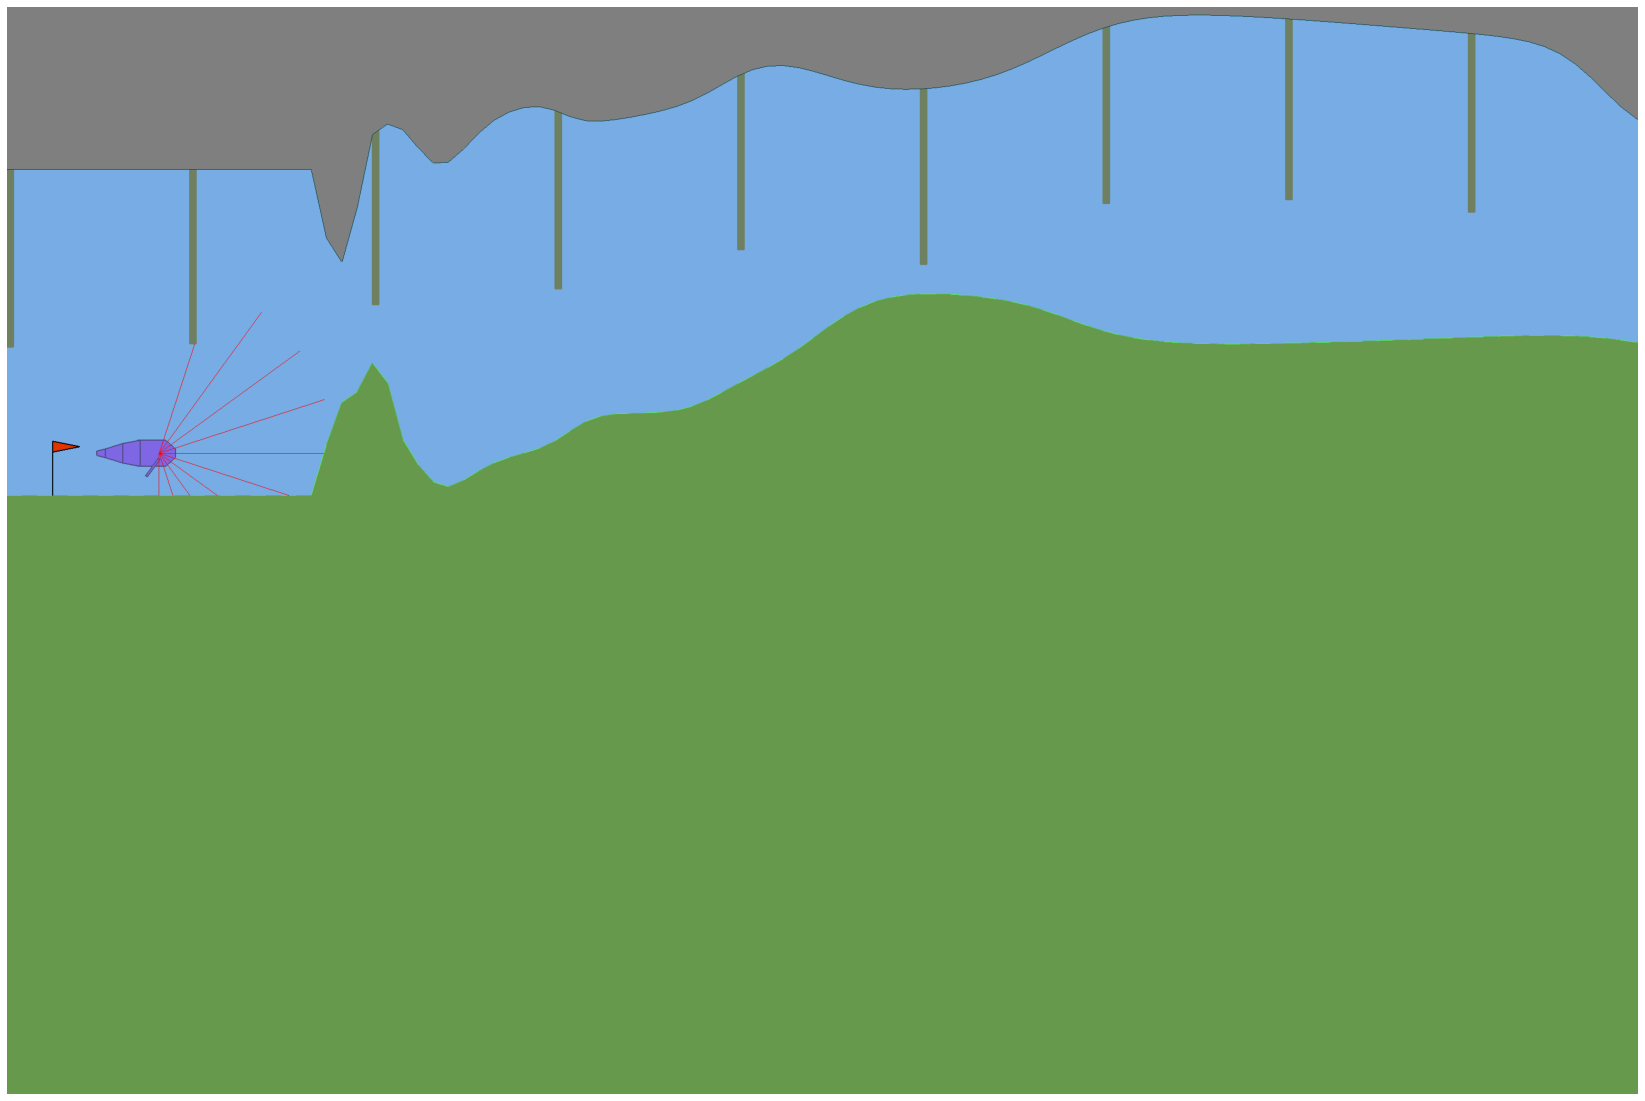

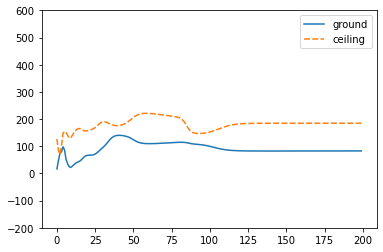

In [23]:
plot_env_and_params(env, lambda vals: vals, 
                   [{"vals": [0, 0, 0]}, 
                    {"vals": [1.0]},
                    {"vals": [0.2]},
                    {"vals": [5.5]},
                    {"vals": [5.0]},
                    {"vals": [20.0]}],
                   nb_of_samples = 1, scroll=[0,-15])

Sample nb 0
Sampled input :
[[-0.072, 0.83, 0.02], 0.65, 0, 0, 0, 20]


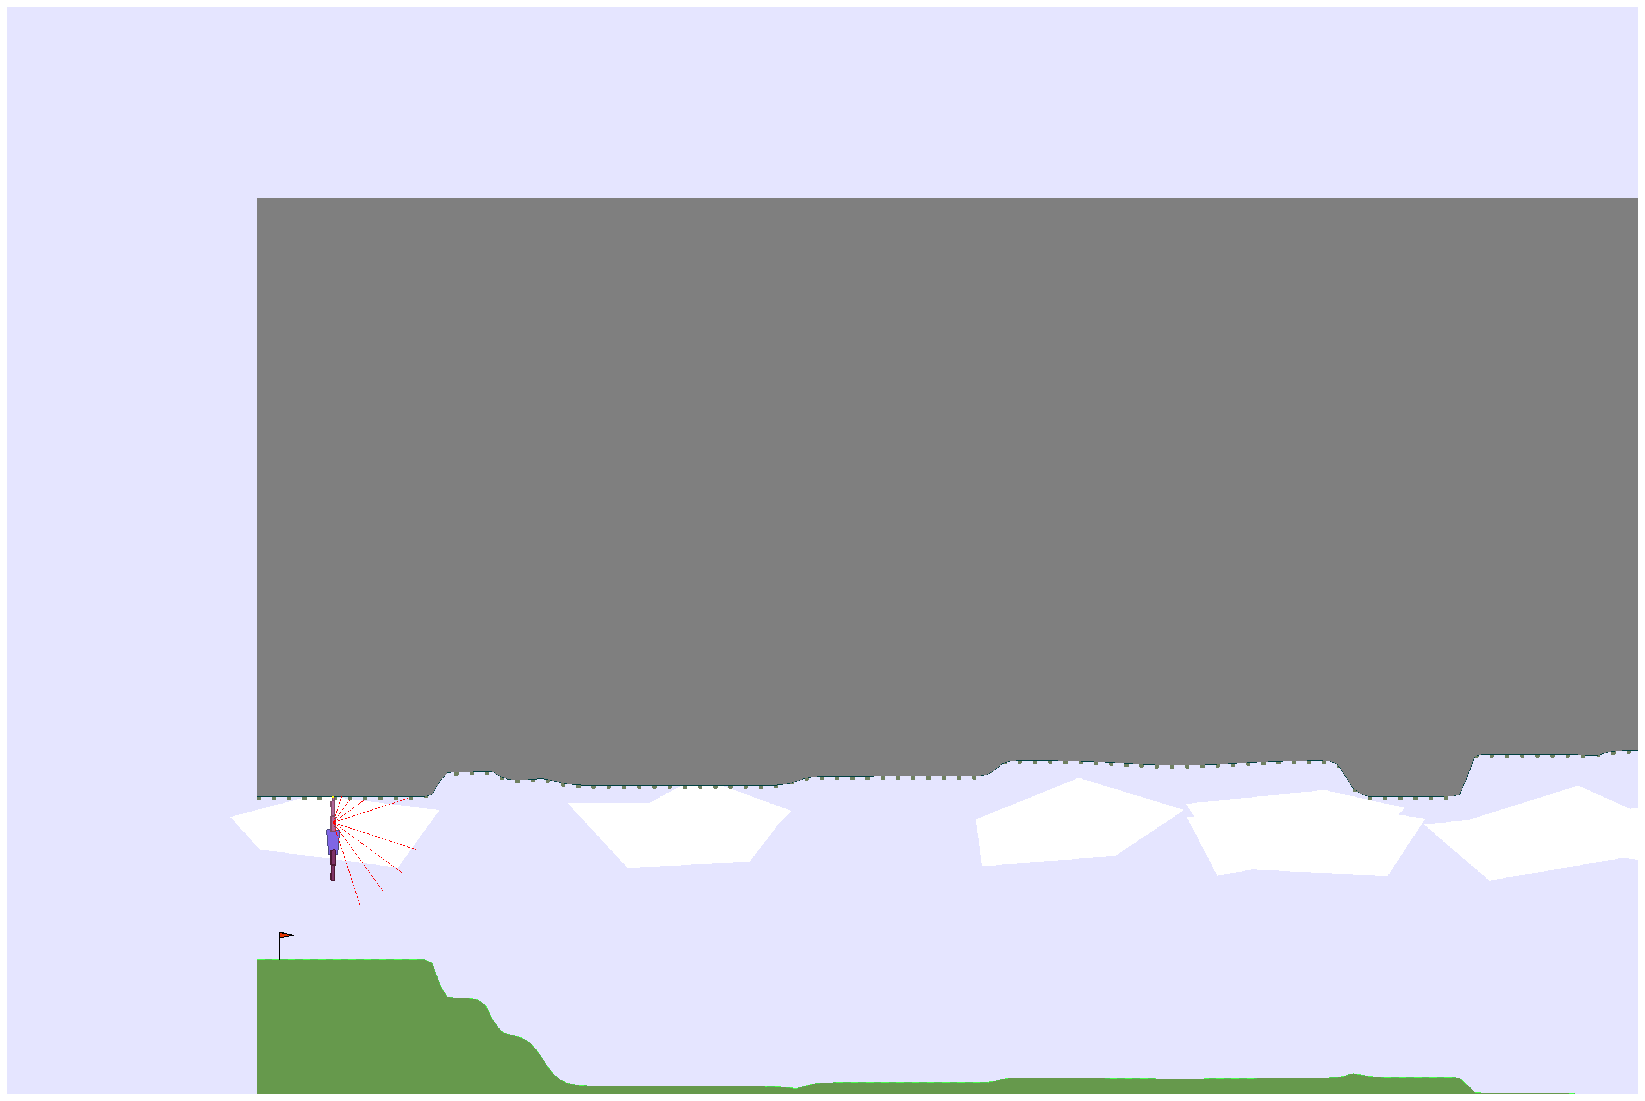

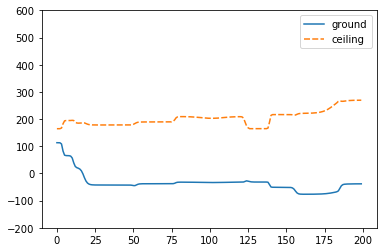

In [37]:
plot_env_and_params(env, lambda vals: vals, 
                   [{"vals": [-0.072, 0.83, 0.02]}, {"vals": [0.65]},
                   {"vals":[0]},{"vals":[0]},{"vals":[0]},{"vals":[20]}],
                   nb_of_samples = 1)

### Input space explo

In [22]:
widget_dim1 = widgets.FloatSlider(min=-1.0, max=1.0, step=0.001)
widget_dim2 = widgets.FloatSlider(min=-1.0, max=1.0, step=0.001)
widget_dim3 = widgets.FloatSlider(min=-1.0, max=1.0, step=0.001)
widget_dim4 = widgets.FloatSlider(min=0, max=1.0, step=0.001)
widget_dim5 = widgets.FloatSlider(min=0.2, max=4.0, step=0.1)
widget_dim6 = widgets.FloatSlider(min=0.1, max=5.0, step=0.1)
widget_dim7 = widgets.FloatSlider(min=10.0, max=20.0, step=1.0)

def printer(dim1, dim2, dim3, water_dim, creepers_height, creepers_spacing, smoothing):
    plot_env_and_params(env, lambda vals: vals, 
                       [{"vals": [dim1, dim2, dim3]}, 
                        {"vals": [water_dim]}, 
                        {"vals": [0.25]}, 
                        {"vals": [creepers_height]}, 
                        {"vals": [creepers_spacing]},
                        {"vals": [smoothing]}],
                       nb_of_samples = 1, scroll=[0, -15])
widgets.interact(printer, dim1=widget_dim1, dim2=widget_dim2, dim3=widget_dim3, water_dim=widget_dim4, 
                 creepers_height=widget_dim5, creepers_spacing=widget_dim6, smoothing=widget_dim7);

interactive(children=(FloatSlider(value=0.0, description='dim1', max=1.0, min=-1.0, step=0.001), FloatSlider(v…

### Sampling

In [38]:
def uniform_input_sampler(size = 3, min = -1.0, max = 1.0):
    return random_state.uniform(min, max, size=(size)).astype(np.float)

In [39]:
def normal_input_sampler(size = 3, min = -1.0, max = 1.0, mean=0, std=0.1):
    return np.clip(random_state.normal(mean, std, size=(size)).astype(np.float), min, max)

In [ ]:
plot_env_and_params(env, uniform_input_sampler, 
                   [{"size": 3, "min": -1.0, "max": 1.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0}],
                    nb_of_samples = 20)

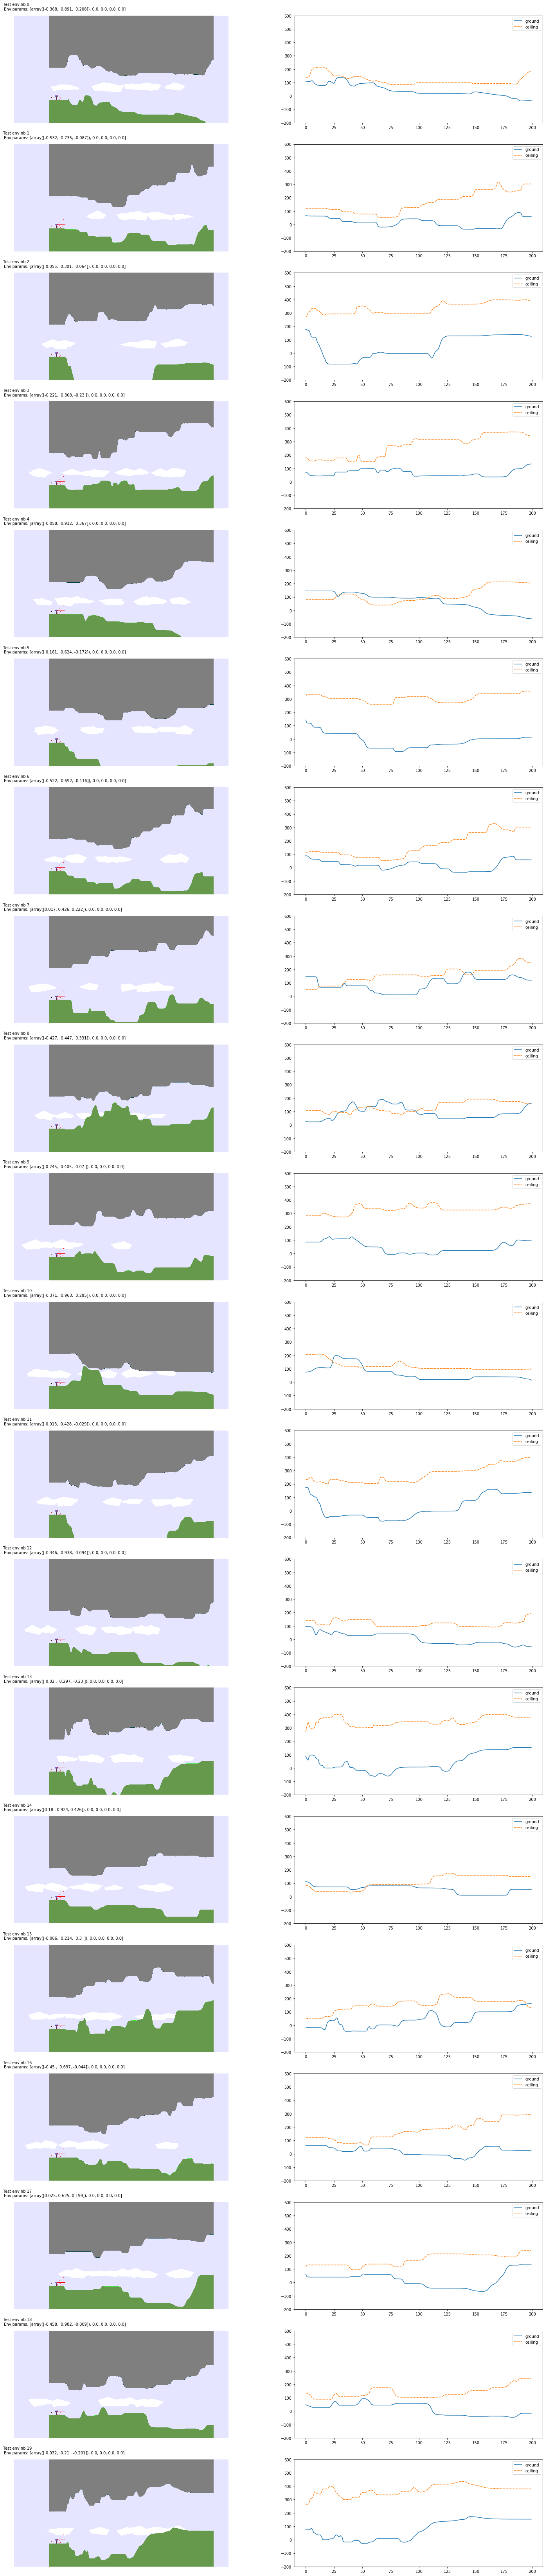

In [46]:
plot_env_and_params(env, uniform_input_sampler, 
                   [{"size": 3, "min": [-0.55, 0.2, -0.3], "max": [0.25, 1.0, 0.5]},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0}],
                    nb_of_samples = 20)

Sample nb 0
Sampled input :
[array([0.05      , 0.88668999, 0.3       ]), 0.0, 0.0, 0.0, 0.0, 20.0]


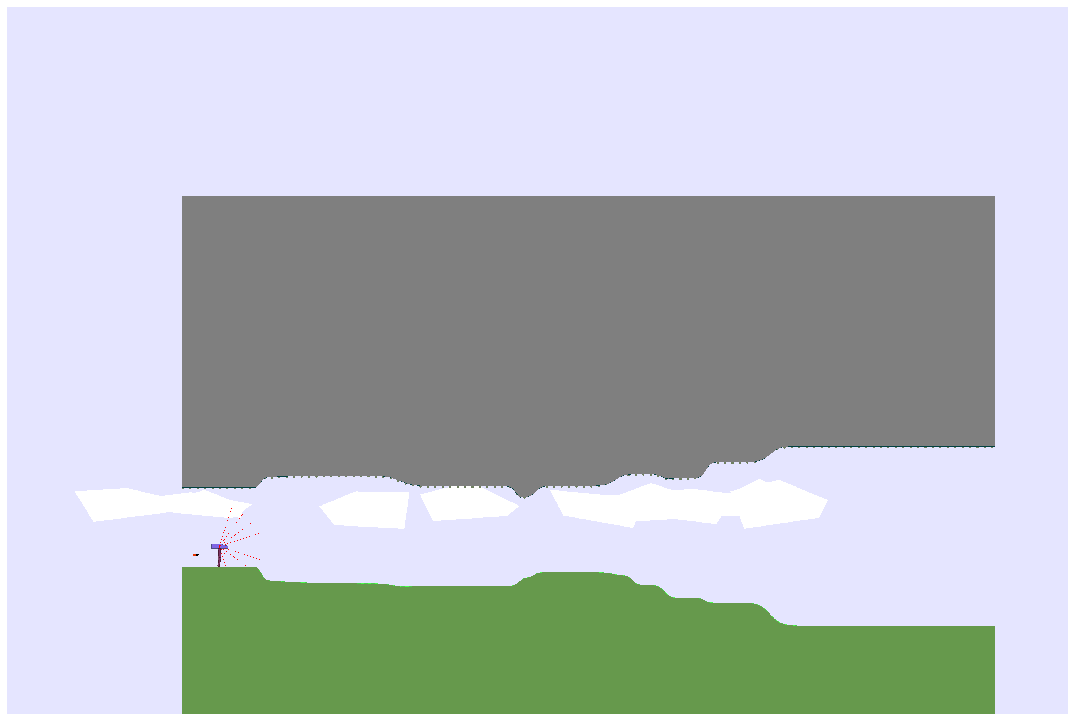

Sample nb 1
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


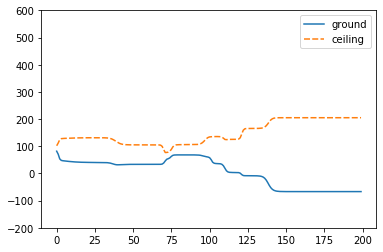

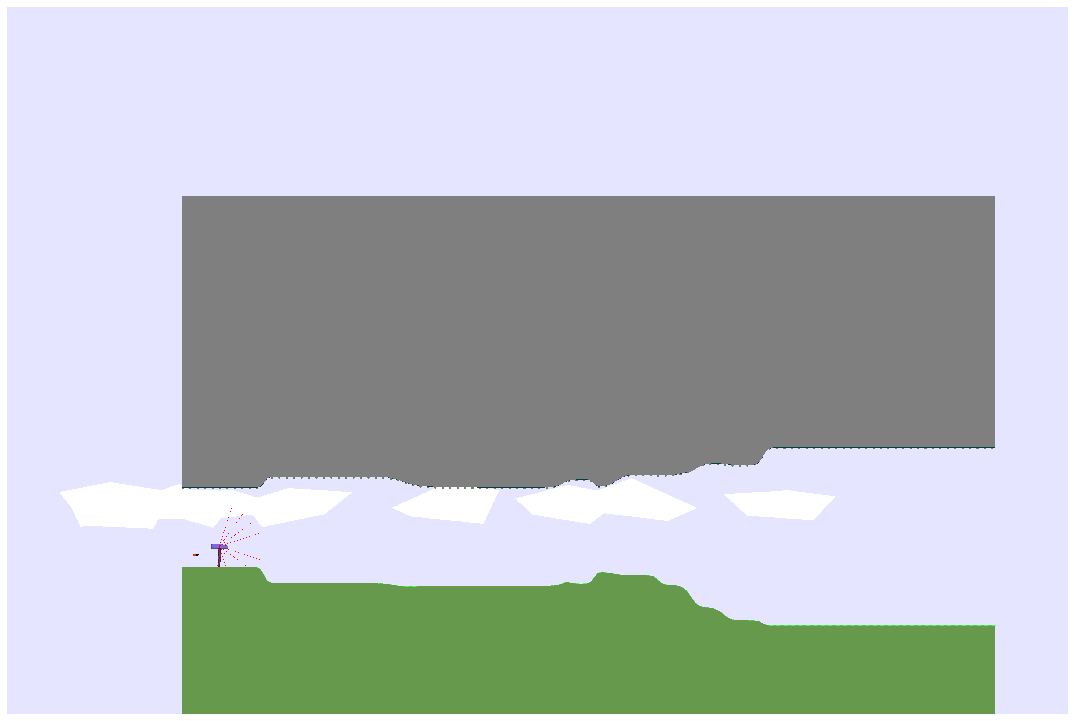

Sample nb 2
Sampled input :
[array([0.05     , 0.9335307, 0.3      ]), 0.0, 0.0, 0.0, 0.0, 20.0]


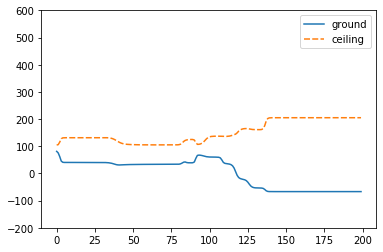

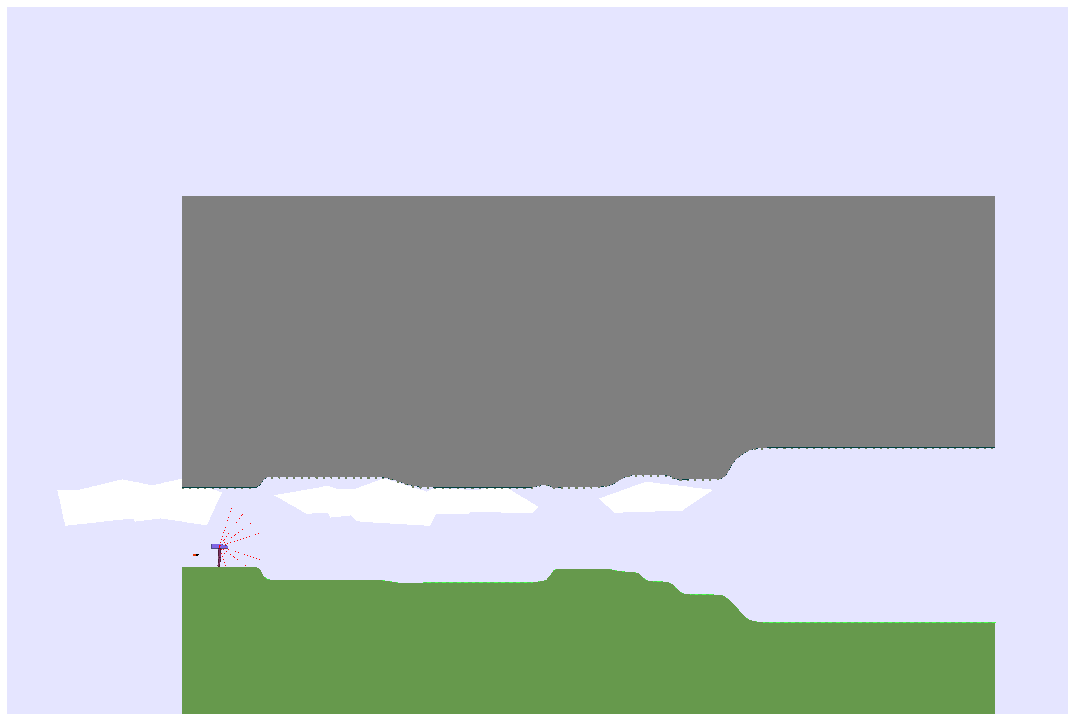

Sample nb 3
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


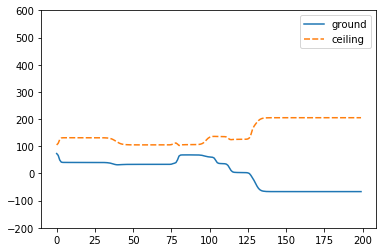

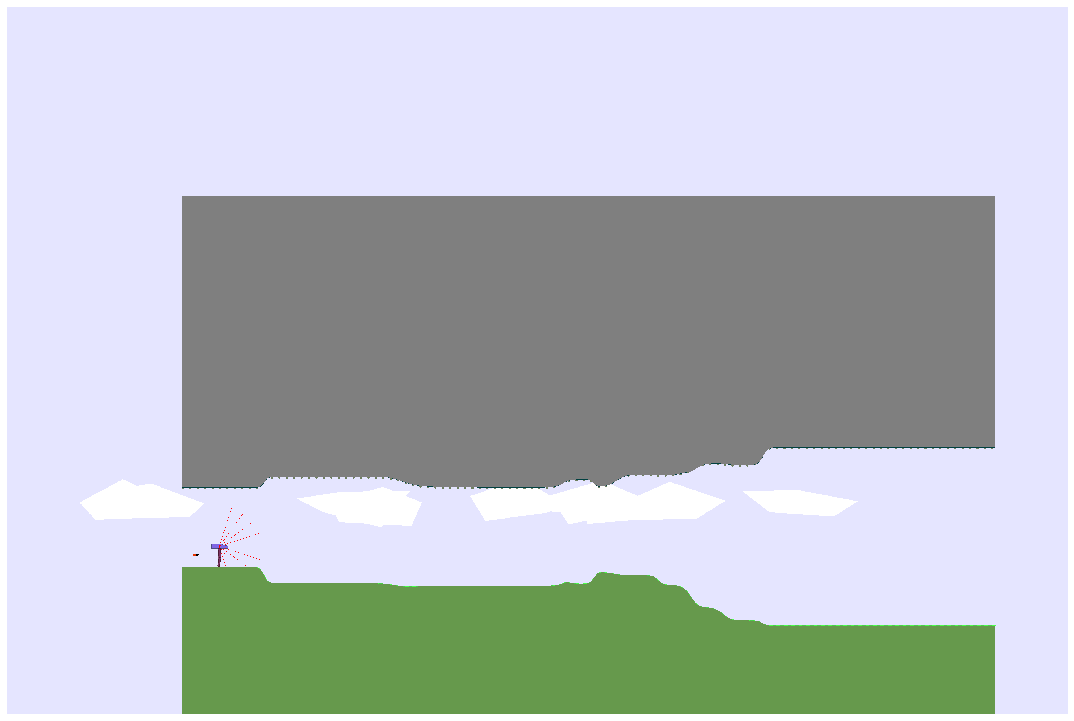

Sample nb 4
Sampled input :
[array([0.05      , 0.89685519, 0.3       ]), 0.0, 0.0, 0.0, 0.0, 20.0]


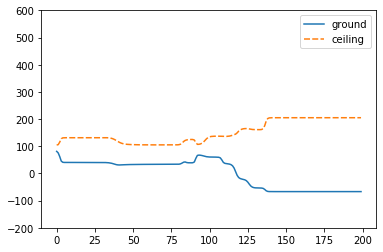

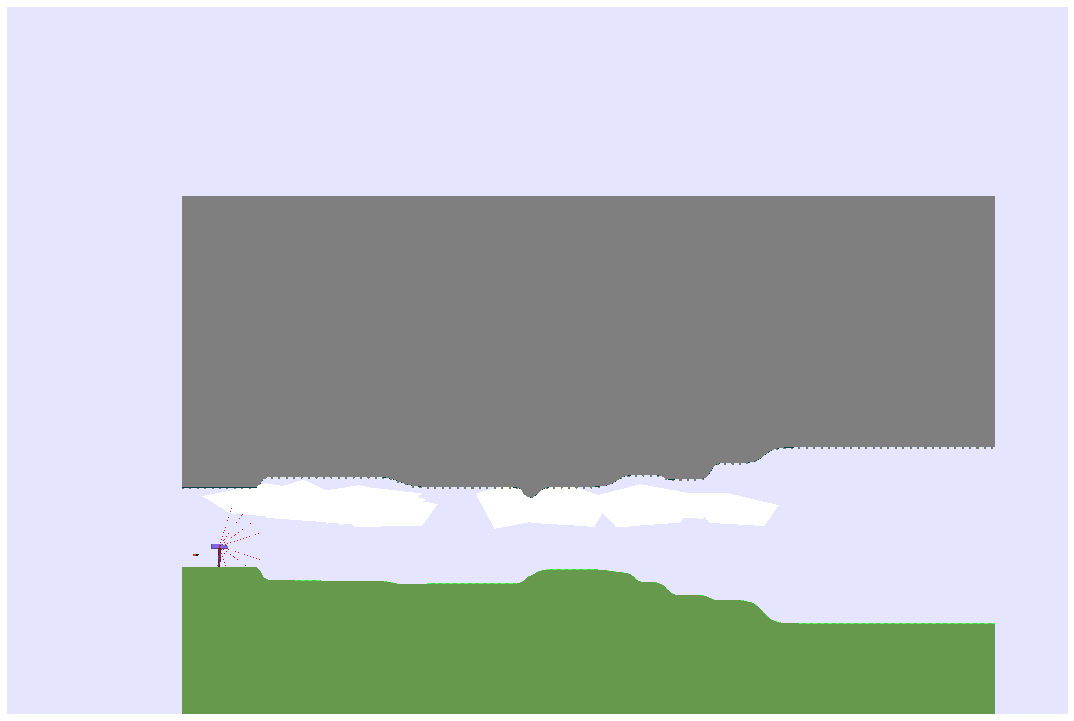

Sample nb 5
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


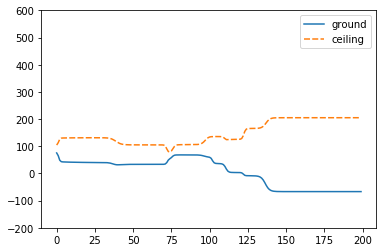

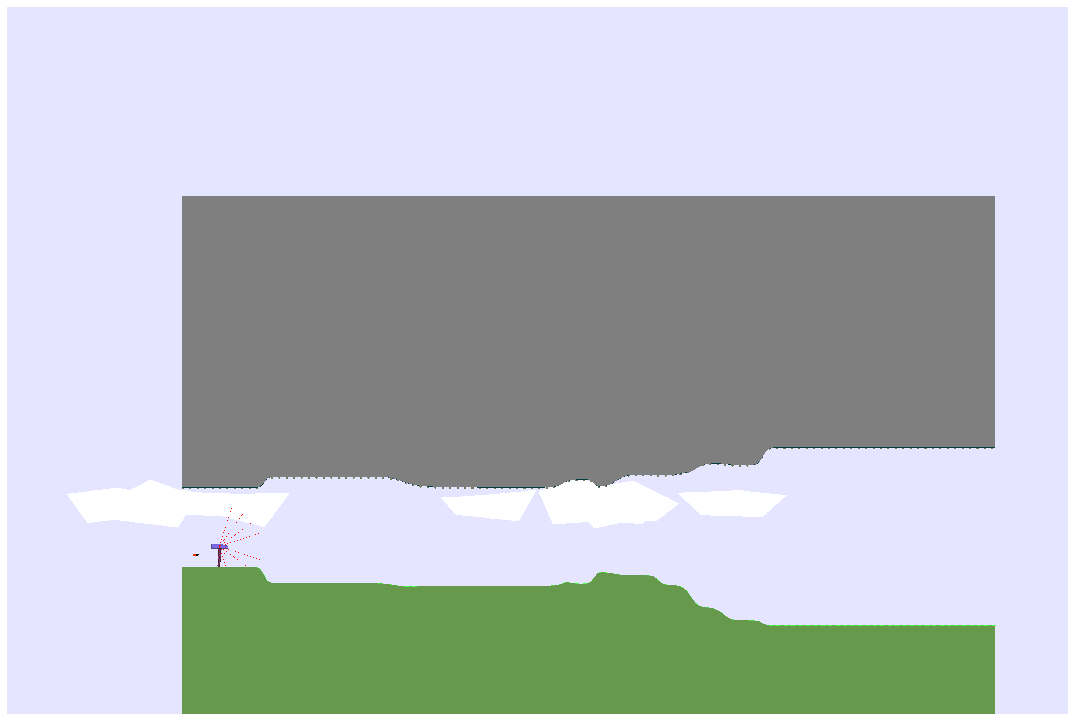

Sample nb 6
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


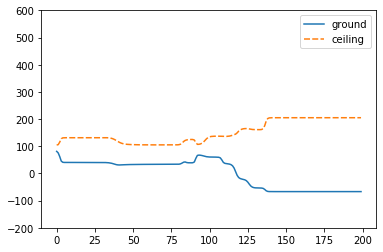

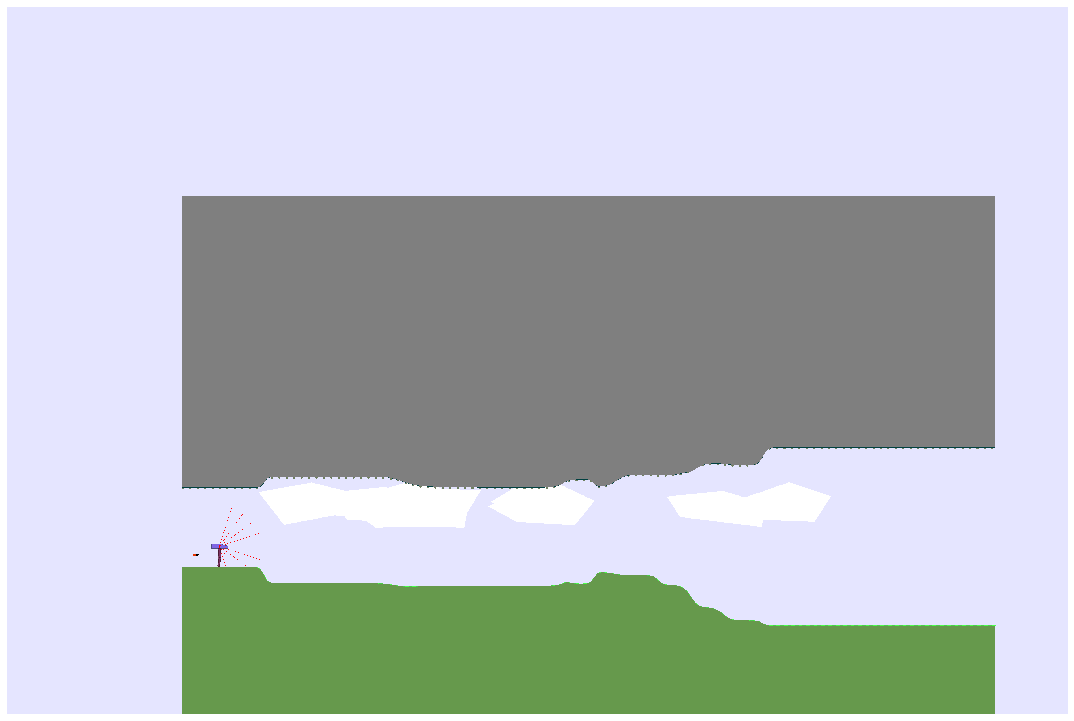

Sample nb 7
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


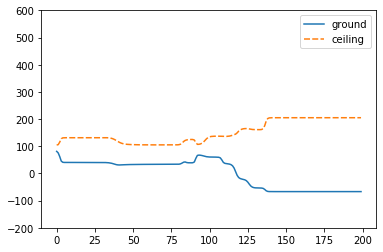

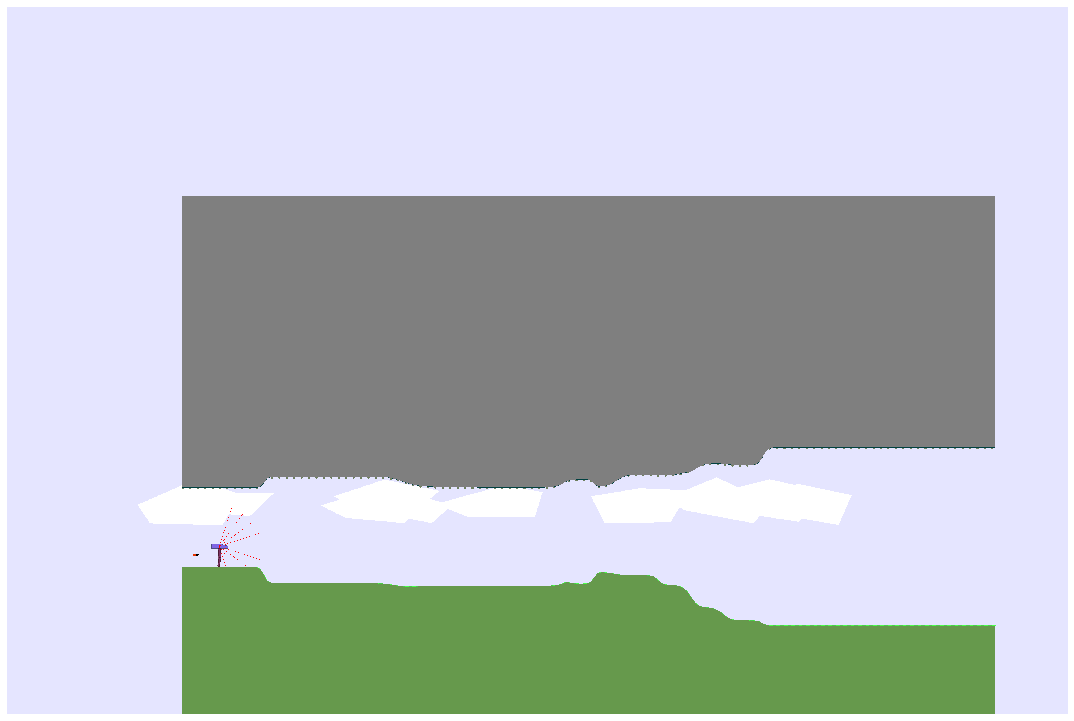

Sample nb 8
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


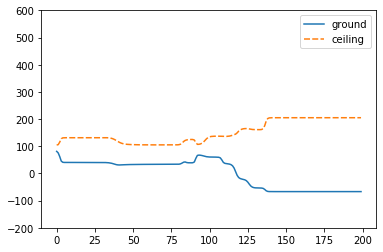

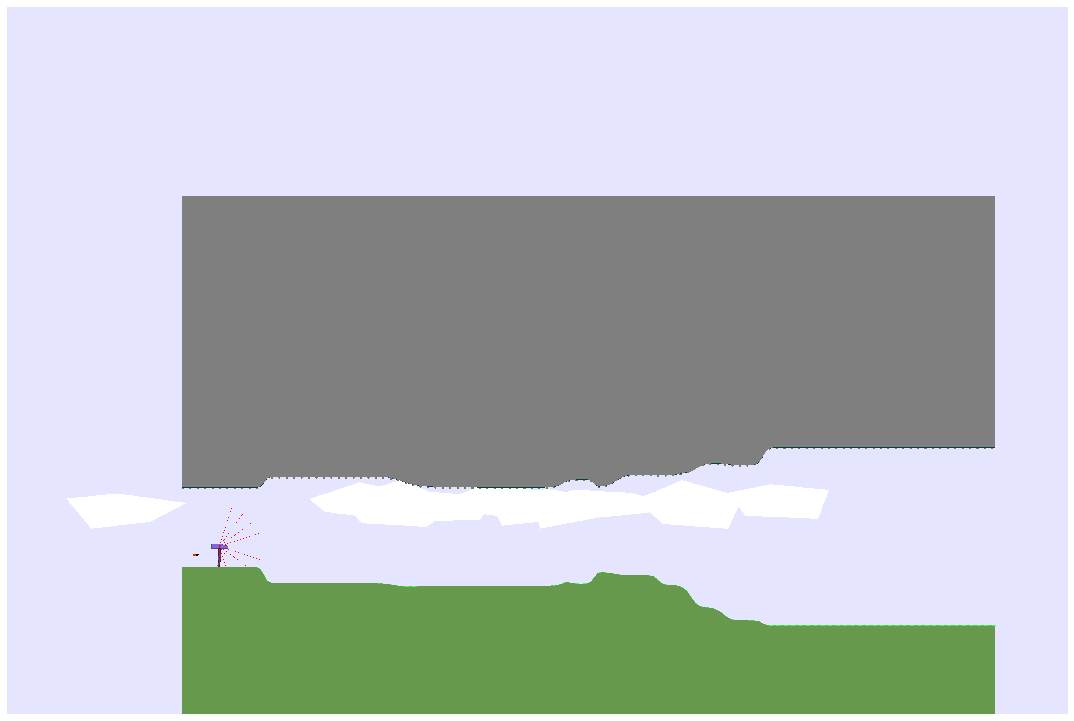

Sample nb 9
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


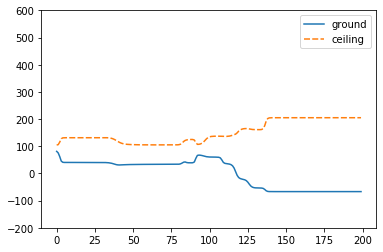

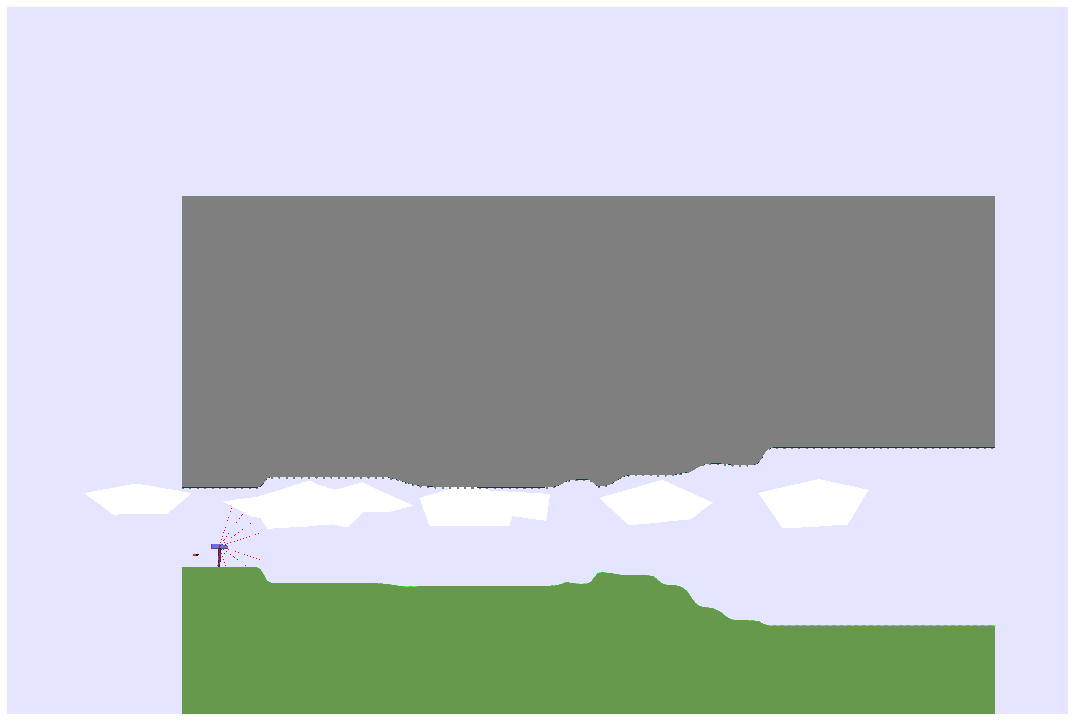

Sample nb 10
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


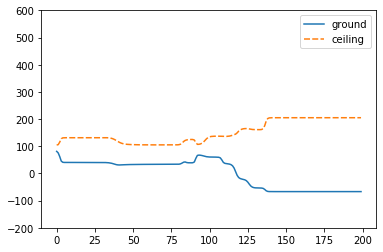

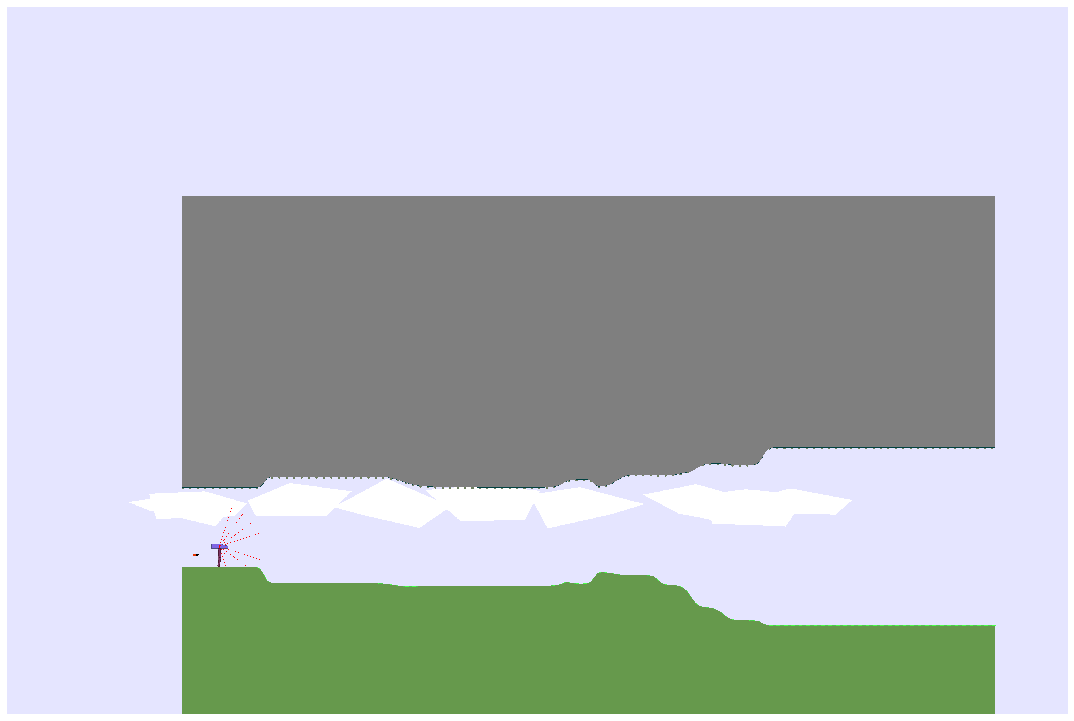

Sample nb 11
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


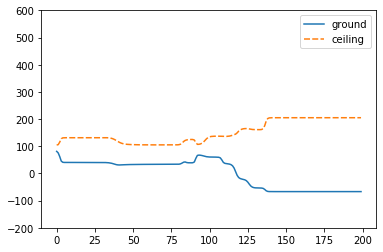

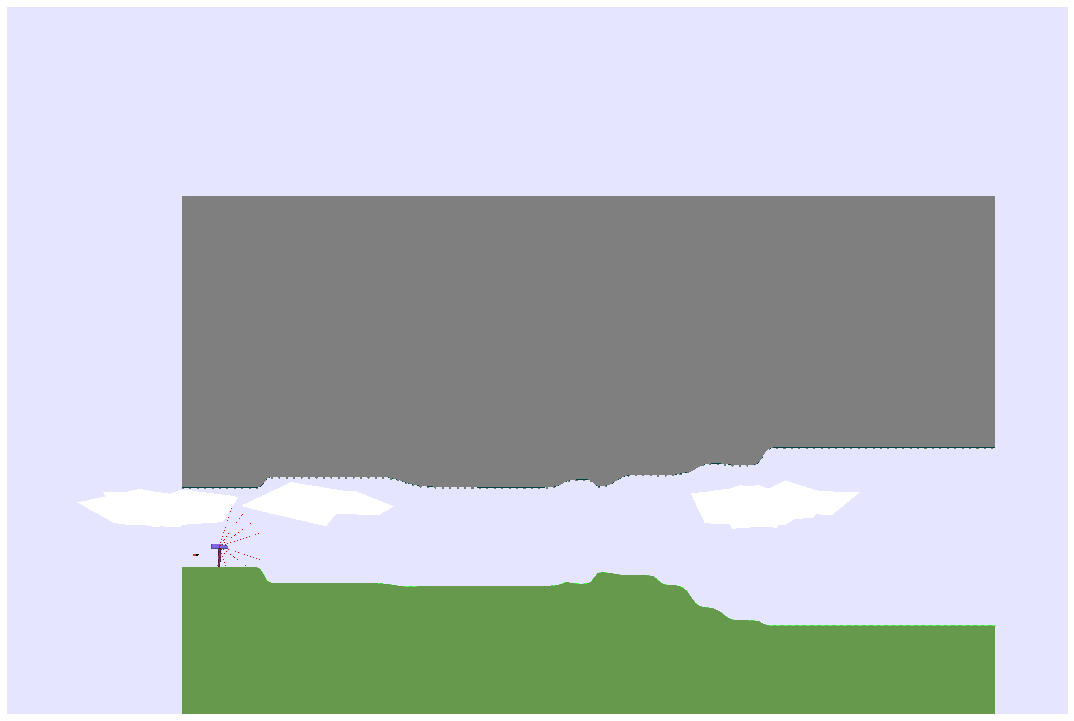

Sample nb 12
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


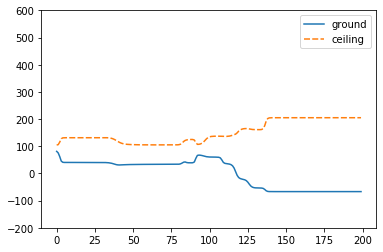

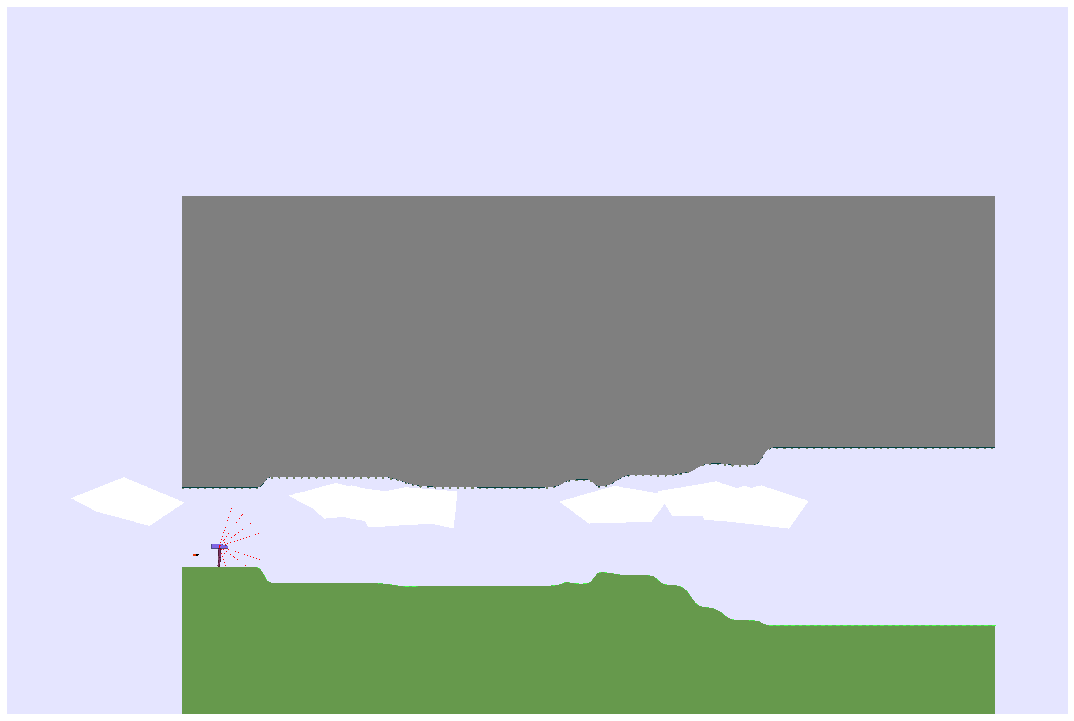

Sample nb 13
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


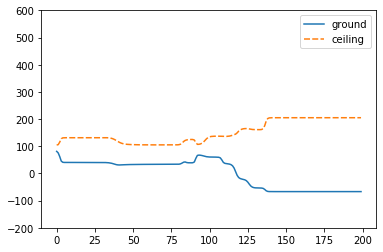

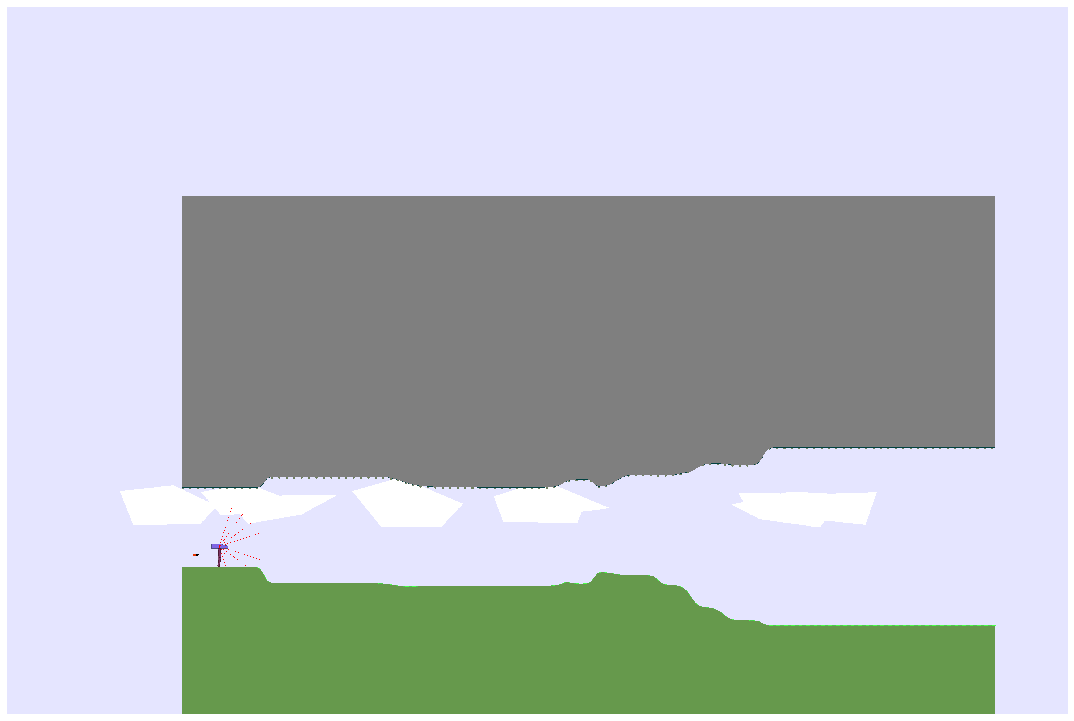

Sample nb 14
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


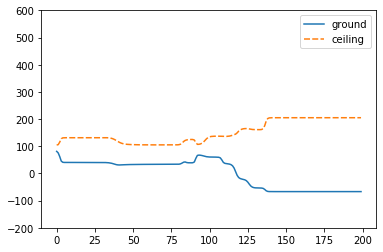

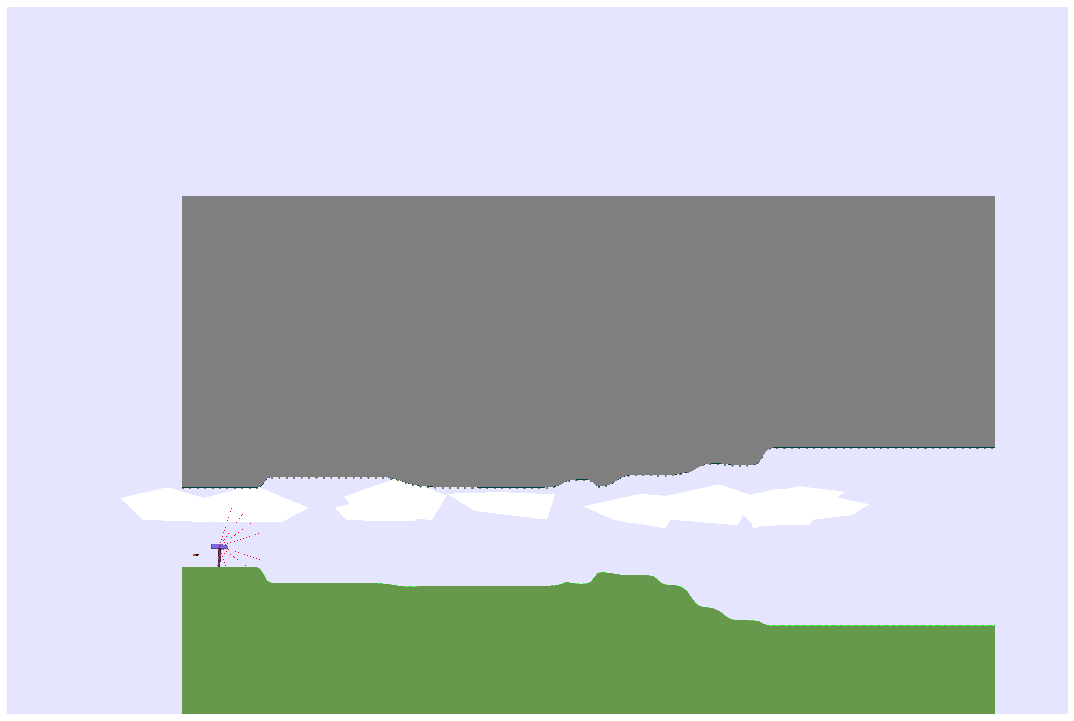

Sample nb 15
Sampled input :
[array([0.05, 1.  , 0.3 ]), 0.0, 0.0, 0.0, 0.0, 20.0]


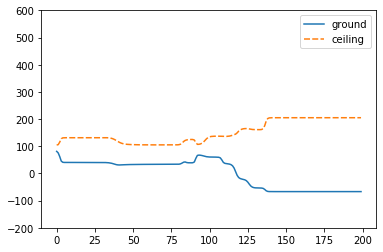

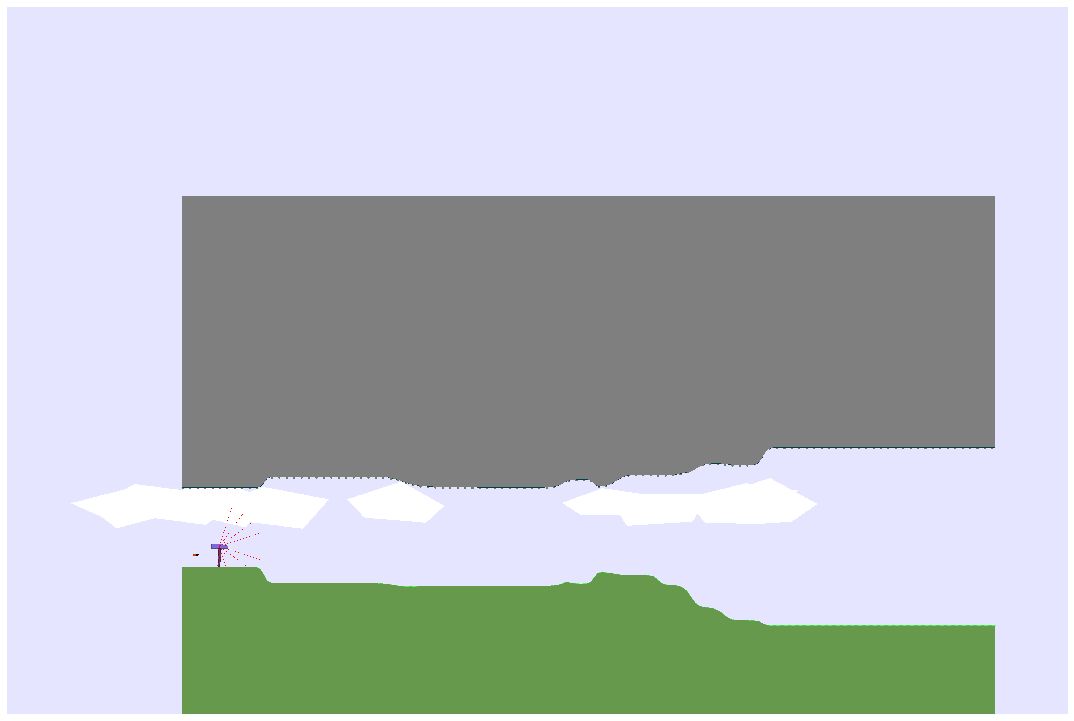

Sample nb 16
Sampled input :
[array([0.05      , 0.93208194, 0.3       ]), 0.0, 0.0, 0.0, 0.0, 20.0]


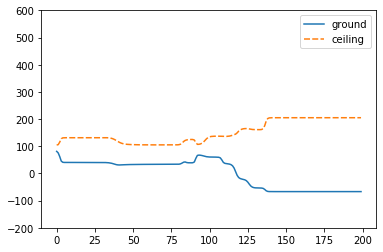

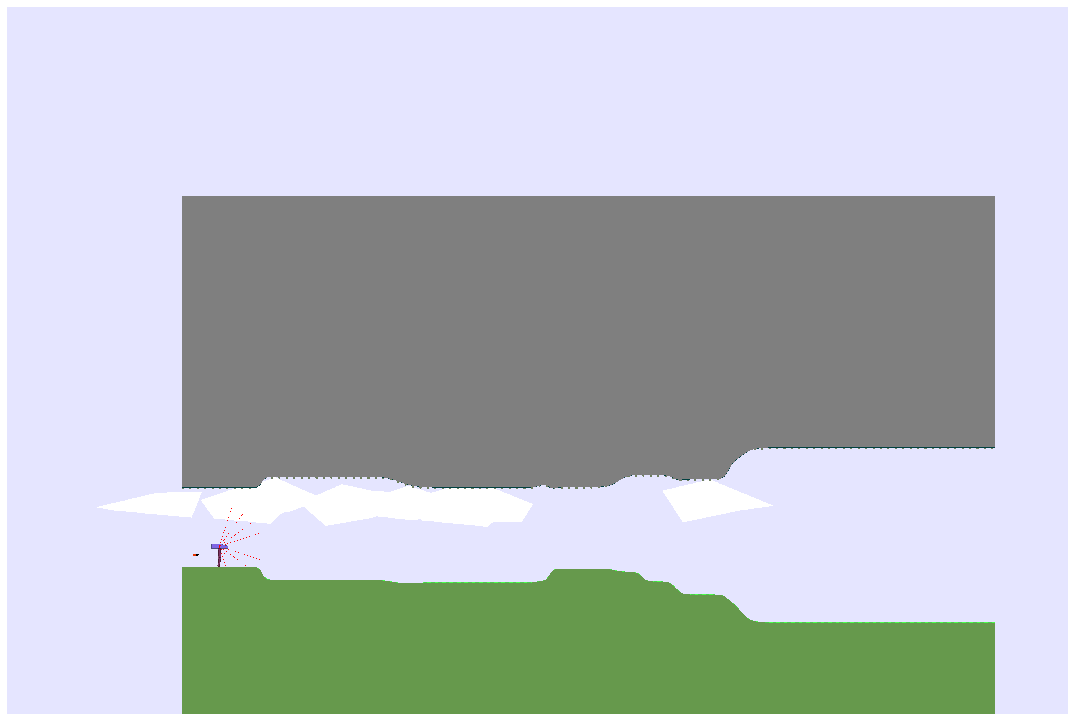

Sample nb 17
Sampled input :
[array([0.05      , 0.95276043, 0.3       ]), 0.0, 0.0, 0.0, 0.0, 20.0]


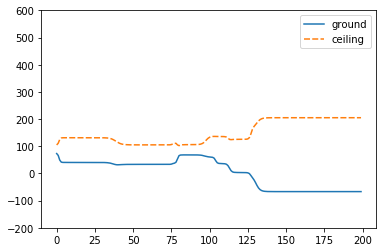

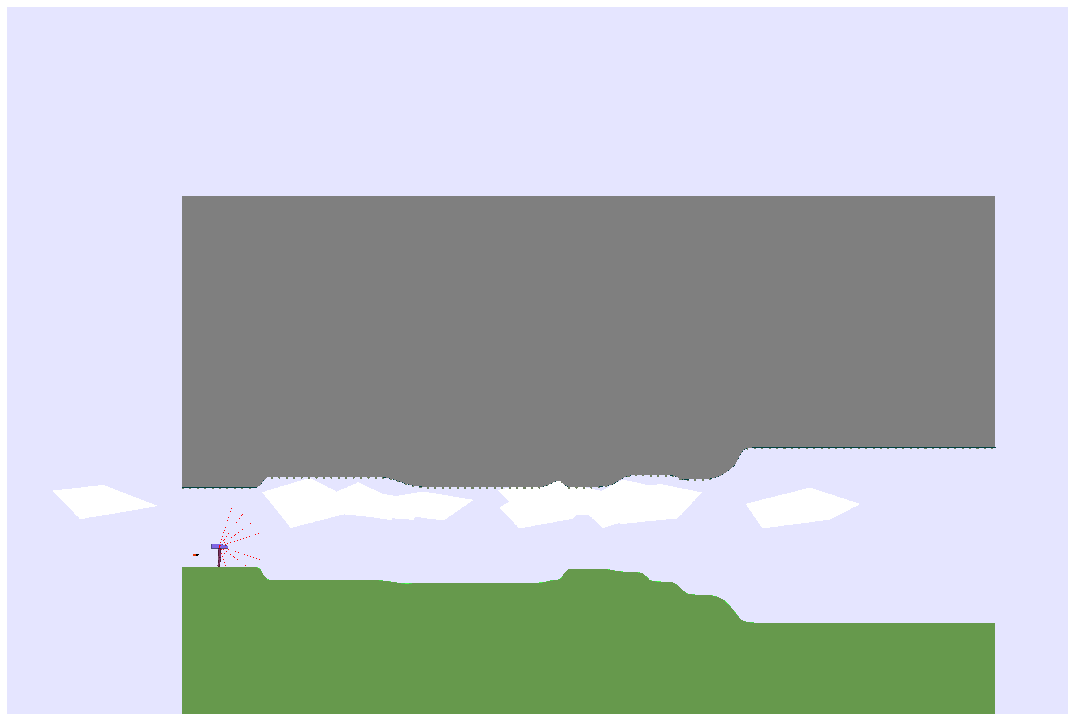

Sample nb 18
Sampled input :
[array([0.05      , 0.97163433, 0.3       ]), 0.0, 0.0, 0.0, 0.0, 20.0]


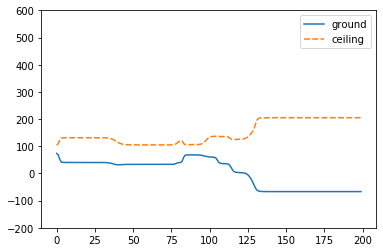

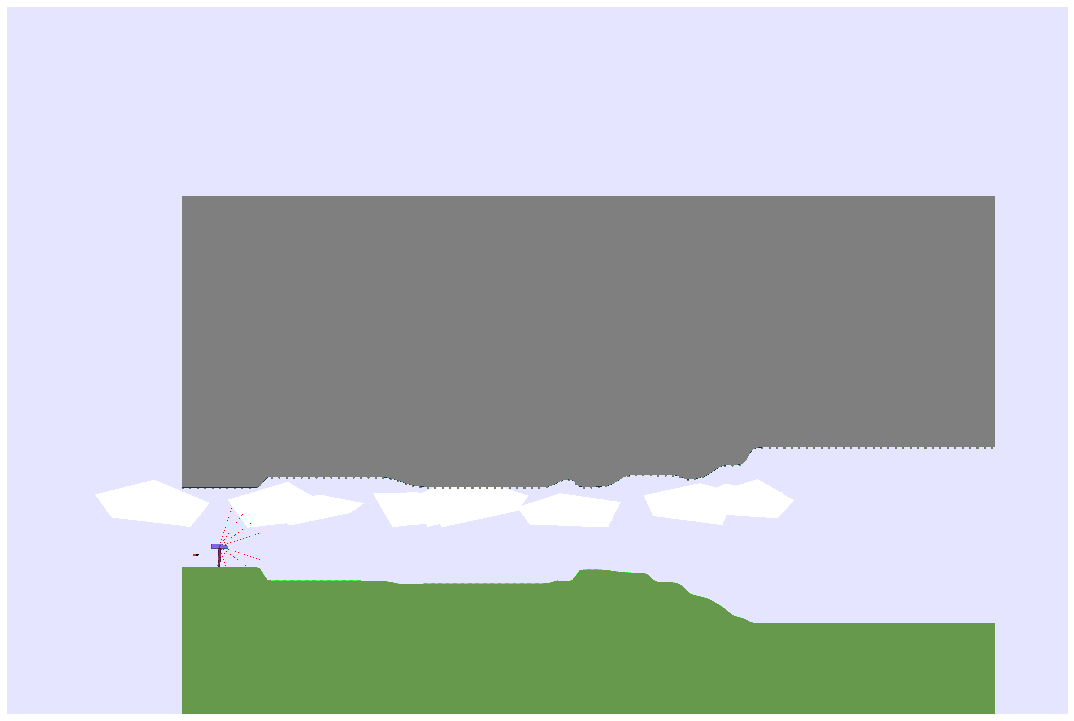

Sample nb 19
Sampled input :
[array([0.05      , 0.97773576, 0.3       ]), 0.0, 0.0, 0.0, 0.0, 20.0]


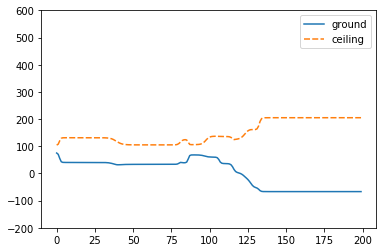

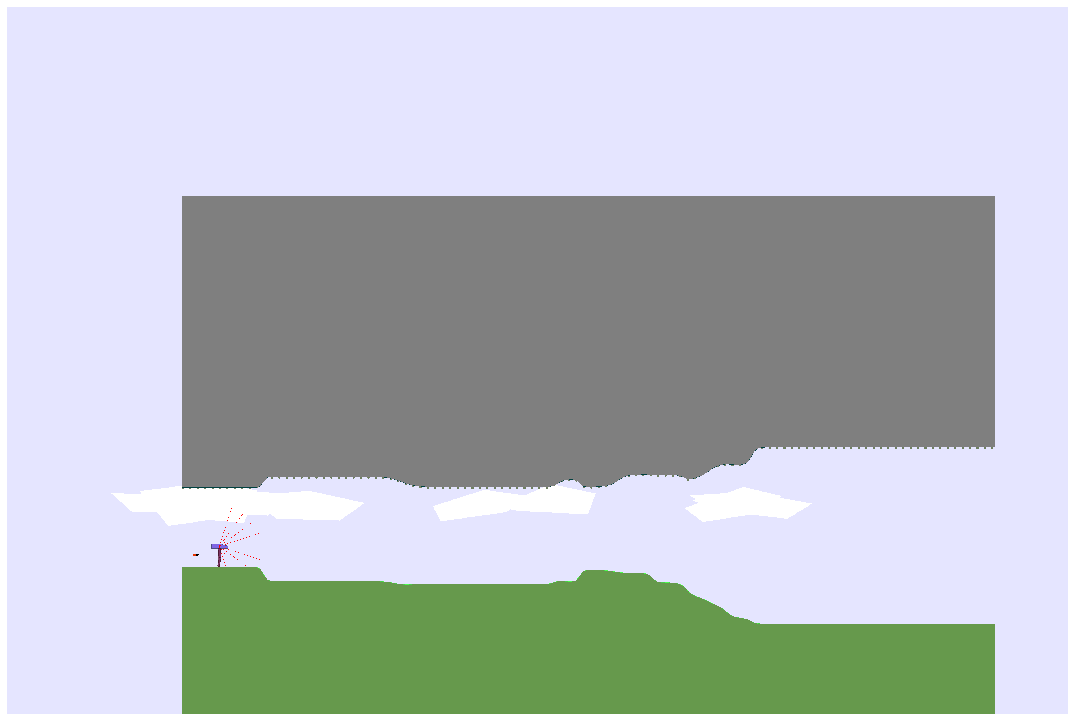

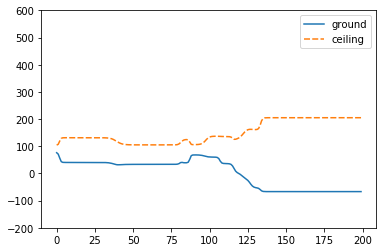

In [41]:
plot_env_and_params(env, normal_input_sampler, 
                   [{"size": 3, "min": [-0.35, 0.6, -0.1], "max": [0.05, 1.0, 0.3], "mean":[0.743, 1.0, 1.0]},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 0.0, "max": 0.0},
                   {"size": 1, "min": 20.0, "max": 20.0}],
                    nb_of_samples = 20)